# Relax Inc. Take-Home Challenge

A user table ( "takehome_users" ) with data on 12,000 users who signed up for the
product in the last two years. This table includes:

    ● name: the user's name
    ● object_id: the user's id
    ● email: email address
    ● creation_source: how their account was created. This takes on one of 5 values:
        ○ PERSONAL_PROJECTS: invited to join another user's personal workspace
        ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)
        ○ ORG_INVITE: invited to an organization (as a full member)
        ○ SIGNUP: signed up via the website
        ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
    ● creation_time: when they created their account
    ● last_session_creation_time: unix timestamp of last login
    ● opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    ● enabled_for_marketing_drip: whether they are on the regular marketing email drip
    ● org_id: the organization (group of users) they belong to
    ● invited_by_user_id: which user invited them to join (if applicable).

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
df_engage = pd.read_csv('takehome_user_engagement.csv')
df_engage.head()


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Define adopted user

In [33]:
print('Users: {}; Total logins: {}'.format(df_engage['user_id'].nunique(), len(df_engage)))

Users: 8823; Total logins: 207917


In [34]:
df_engage['time_stamp'] = pd.to_datetime(df_engage['time_stamp'], format='%Y-%m-%d %H:%M:%S')

In [35]:
# Defining an "adopted user" as a user who has logged into the product on three separate days in at least one sevenday period
def logins_in_days(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

In [36]:
from datetime import timedelta
adopted = df_engage.groupby('user_id').apply(logins_in_days)
adopted.name = 'adopted_user'
df_engage['adopted_user'] = adopted

In [37]:
print('Adopted users: {}; Total users: {}'.format(sum(adopted), len(adopted)))

Adopted users: 1656; Total users: 8823


In [38]:
df_engage.head()

,time_stamp,user_id,visited,adopted_user
0,2014-04-22 03:53:30,1,1,NaN
1,2013-11-15 03:45:04,2,1,False
2,2013-11-29 03:45:04,2,1,True
3,2013-12-09 03:45:04,2,1,False
4,2013-12-25 03:45:04,2,1,False


In [39]:
df_engage['adopted_user'] = df_engage['adopted_user'].fillna(False)

In [40]:
df_engage.head()

,time_stamp,user_id,visited,adopted_user
0,2014-04-22 03:53:30,1,1,False
1,2013-11-15 03:45:04,2,1,False
2,2013-11-29 03:45:04,2,1,True
3,2013-12-09 03:45:04,2,1,False
4,2013-12-25 03:45:04,2,1,False


## Data Wrangling

In [41]:
df_users = pd.read_csv('takehome_users.csv', encoding='latin-1',parse_dates=True)
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [42]:
df_users = df_users.set_index('object_id')
df_users.index.name = 'user_id'
df_users = pd.concat([df_users, adopted], axis=1, join='inner')
df_users['adopted_user'] = df_users['adopted_user'].astype(int)

In [43]:
df_users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
user_id,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [44]:
import datetime
df_users.creation_time = pd.to_datetime(df_users.creation_time)
df_users['last_session_creation_time'] = df_users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

In [45]:
# Calculate active time
df_users['last_session_creation_time'] = pd.to_datetime(df_users['last_session_creation_time'])
df_users['usage_length'] = df_users['last_session_creation_time'] - df_users['creation_time']
df_users['usage_length'] = [x.total_seconds() for x in df_users['usage_length']]

In [46]:
# Find email provide
df_users['email_provider'] = [x.split('@')[1] for x in df_users.email]
top_emails = df_users.email_provider.value_counts().index[:6]
df_users['email_provider'] = [x if x in top_emails else 'other' for x in df_users.email_provider]

In [47]:
df_users.invited_by_user_id = df_users.invited_by_user_id.fillna(0)

In [49]:
df_users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
user_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-21 23:53:30,1,0,11,10803.0,0,-14400.0,yahoo.com
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-30 23:45:04,0,0,1,316.0,1,11736000.0,gustr.com
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 19:14:52,0,0,94,1525.0,0,-14400.0,gustr.com
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 04:09:28,0,0,1,5151.0,0,72000.0,yahoo.com
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 05:14:20,0,0,193,5240.0,0,414000.0,yahoo.com


## Data Analysis

In [ ]:
for col in ['creation_source','day', 'month', 'invited']:
    sns.countplot(y = col, hue = 'active', data = users )
    plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'GUEST_INVITE'),
  Text(1, 0, 'ORG_INVITE'),
  Text(2, 0, 'SIGNUP'),
  Text(3, 0, 'PERSONAL_PROJECTS'),
  Text(4, 0, 'SIGNUP_GOOGLE_AUTH')])

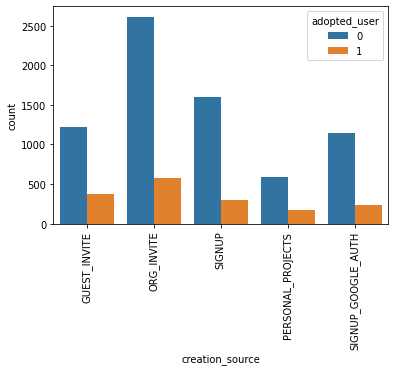

In [50]:
sns.countplot(x='creation_source', data=df_users, hue='adopted_user')
plt.xticks(rotation=90)

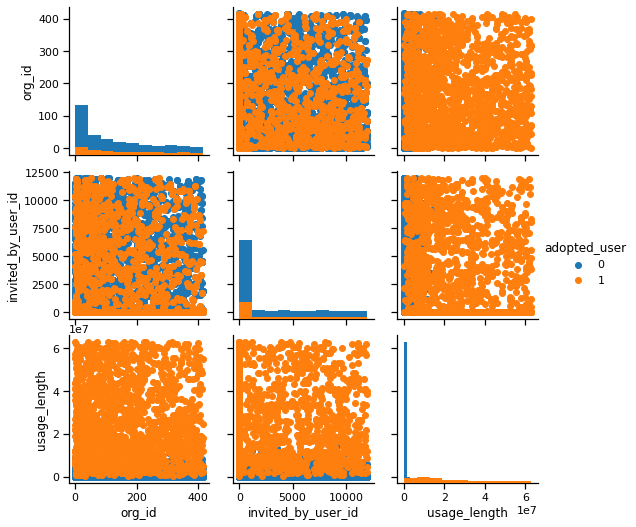

In [51]:
sns.set_context('notebook')
p = sns.PairGrid(df_users,
                 x_vars = ['org_id','invited_by_user_id', 'usage_length'],
                 y_vars = ['org_id','invited_by_user_id', 'usage_length'],
                 hue = 'adopted_user'
                )
p = p.map_diag(plt.hist)
p.map_offdiag(plt.scatter)
p.add_legend()

## Modeling

In [52]:
# Create labels for categorical features
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
creation_labels = gle.fit_transform(df_users['creation_source'])
df_users.creation_source = creation_labels

org_id_labels = gle.fit_transform(df_users['org_id'])
df_users.org_id = org_id_labels

invited_labels = gle.fit_transform(df_users['invited_by_user_id'])
df_users.org_id = invited_labels

email_labels = gle.fit_transform(df_users['email_provider'])
df_users.email_provider = email_labels

In [53]:
df_users.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
user_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,0,2014-04-21 23:53:30,1,0,2024,10803.0,0,-14400.0,6
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1,2014-03-30 23:45:04,0,0,48,316.0,1,11736000.0,2
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1,2013-03-19 19:14:52,0,0,264,1525.0,0,-14400.0,2
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,0,2013-05-22 04:09:28,0,0,967,5151.0,0,72000.0,6
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,0,2013-01-22 05:14:20,0,0,984,5240.0,0,414000.0,6


In [61]:
from sklearn.model_selection import train_test_split
feature_names = ['creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id','usage_length','email_provider']

X = df_users[feature_names]
Y = df_users.adopted_user

X_train, y_train, X_test, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [62]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced_subsample')
rf.fit(X_train, X_test)
rf.score(y_train, y_test)

0.955043445409898

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rf.predict(y_train)
cm= confusion_matrix(y_test,y_pred)

print(classification_report(y_test, y_pred))
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2136
           1       0.90      0.86      0.88       511

    accuracy                           0.96      2647
   macro avg       0.94      0.92      0.93      2647
weighted avg       0.95      0.96      0.95      2647

confusion matrix:
[[2090   46]
 [  73  438]]


### Feature Importance

In [64]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(X.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.908028
org_id                        0.029147
invited_by_user_id            0.028590
email_provider                0.016785
creation_source               0.009560
opted_in_to_mailing_list      0.004485
enabled_for_marketing_drip    0.003406
Name: coef, dtype: float64

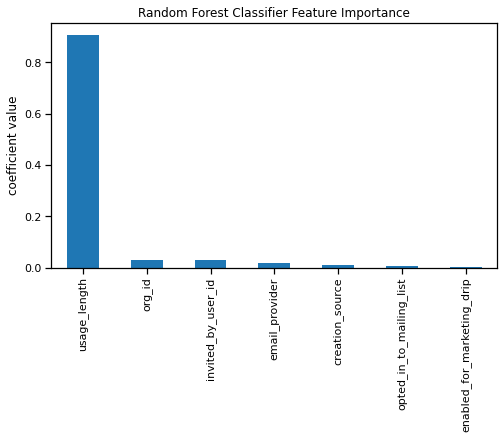

In [67]:
plt.figure(figsize=(8,4.5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

In [68]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [69]:
adopted = df_users.usage_length.loc[df_users['adopted_user'] == 1]
not_adopted = df_users.usage_length.loc[df_users['adopted_user'] == 0]

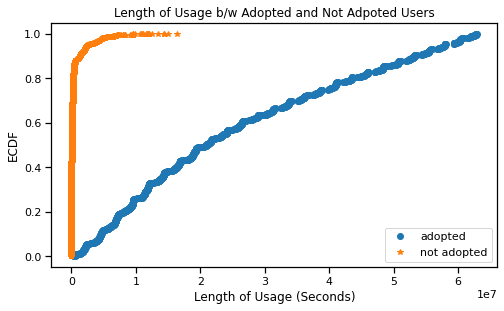

In [70]:
plt.figure(figsize=(8,4.5))

x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)

plt.plot(x_active, y_active, marker='o', linestyle='none')
plt.plot(x_inactive, y_inactive, marker='*', linestyle='none')
plt.title('Length of Usage b/w Adopted and Not Adpoted Users')
plt.xlabel('Length of Usage (Seconds)')
plt.ylabel('ECDF')
plt.legend(['adopted', 'not adopted'])
plt.show()

The length of time between a user signing up and last active session can be greatest indicator of whether or not the user becames an adopted user. As shown in ECDF results, at the maxium time usage of non-adopted users, approximately 50% of the active users have usage above that amount of time (approximately 230 days).